## Imports

In [1]:
import pandas as pd
from scipy.stats import wasserstein_distance
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

/Users/keshvigupta/Library/Caches/pypoetry/virtualenvs/debiasing-text-with-style-transfer-2Fg498RO-py3.9/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# BERT model
CLS_MODEL_PATH = "../../../models/bert-finetuned"
model_sc = AutoModelForSequenceClassification.from_pretrained(CLS_MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(CLS_MODEL_PATH)

# Calculate Content Preservation Score
model_st = SentenceTransformer('bert-base-nli-mean-tokens')
cls_explainer = SequenceClassificationExplainer(model_sc, tokenizer)

## Explaination of Evaluation Metrics
The metrics we will use are:

**1. Style Transfer Intensity (STI)**

The STI metric is used to measure how much a
style transfer model has changed the style of a text sample.

**2. Content Preservation Score (CPS)**

The CPS metric is used to measure how well a
style transfer model preserves the original content of a text sample.


In [2]:
# Load the CSV file
file_path = '../../data/baseline_evaluated.csv'
df = pd.read_csv(file_path)

# Ensure the column names match CSV file's column names
source_label_0_col = 'source_label_0'
source_label_1_col = 'source_label_1'
target_label_0_col = 'target_label_0'
target_label_1_col = 'target_label_1'
predicted_label_0_col = 'predicted_label_0'  
predicted_label_1_col = 'predicted_label_1'

## Style Transfer Intensity (STI) calculation using Earth Mover's Distance
1. EMD Calculation

EMD is calculated between the style distributions (probabilities) of the source text and the predicted text, as well as between the target text and the predicted text.

2. Style Distributions

The style distribution for each text type (source, target, predicted) is represented by the probabilities that the text is neutral or subjective. These are stored in the columns like source_label_0, source_label_1, etc.

3. EMD for Source-Predicted

For each pair of source and predicted texts, EMD measures how much the style of the text has shifted after the style transfer. A lower EMD indicates a smaller shift, suggesting that the predicted text retains much of the source text's style.

4. EMD for Target-Predicted

Similarly, EMD between the target and predicted texts measures how close the style of the predicted text is to the desired target style. A lower EMD here indicates that the predicted text closely matches the target style.

### Exploration

In [3]:
# Calculate EMD for Style Transfer Intensity (STI)

# Here, 'source_label_0' and 'source_label_1' are the probabilities for the source text being neutral and subjective, respectively
# Similarly for 'target_label_0', 'target_label_1', 'predicted_label_0', and 'predicted_label_1'

emd_source_predicted = [wasserstein_distance([row[source_label_0_col], row[source_label_1_col]],
                                              [row[predicted_label_0_col], row[predicted_label_1_col]])
                        for index, row in df.iterrows()]
emd_target_predicted = [wasserstein_distance([row[target_label_0_col], row[target_label_1_col]],
                                              [row[predicted_label_0_col], row[predicted_label_1_col]])
                        for index, row in df.iterrows()]
emd_source_target = [wasserstein_distance([row[target_label_0_col], row[target_label_1_col]],
                                              [row[source_label_0_col], row[source_label_1_col]])
                        for index, row in df.iterrows()]

In [5]:
# Combine results in a new DataFrame
evaluation_df = pd.DataFrame({
    "Source Text": df['source_text'],
    "Target Text": df['target_text'],
    "Predicted Text": df['predicted_text'],
    "EMD Source-Predicted": emd_source_predicted,
    "EMD Target-Predicted": emd_target_predicted,
	"EMD Source-Target": emd_source_target
})

In [6]:
display(evaluation_df.head())

,Source Text,Target Text,Predicted Text,EMD Source-Predicted,EMD Target-Predicted,EMD Source-Target
0,"in april 2009 a brazilian human rights group, ...","in april 2009 a brazilian human rights group, ...","the the is the, the the the the the,,,,,,,,,,,...",0.397700,0.300082,0.097618
1,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,"the the is the, the the the the the,,,,,,,,,,,...",0.220731,0.369325,0.148595
2,"mark oaten ( born 8 march 1964, watford ) is a...","mark oaten ( born 8 march 1964, watford ) is a...","the the is the, the the the the the,,,,,,,,,,,...",0.494251,0.456683,0.037568
3,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,"the the is the, the the the the the the..",0.375979,0.350370,0.025609
4,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,"the the is the, the the the the the the..",0.376436,0.375420,0.001016


We Need to combine the SWD metrics into a single STI. 

This statement has been successfully neutralized by the model (EMD Target-Predicted = 0). However, CPS shows value 0.93. This is due to the blant cosine similarity matching between source and oredicted text. The style transferred word is reducing the CPS score.
Thereofre we need to remove that Word to make CPS more appropriate

Therefore we will refine evaluation metrics

### Calculating STI :

Intuition  :  More 'accurate' style transfer is when prediction is close to target and far away from source.

Logic : STI = (EMD between source and predicted) + (inverse of EMD between target and source)
1. more intuitive
2. Focuses on genuine style transfers
2. penalizes no change in source, target and prediction

In [7]:
evaluation_df.head()

,Source Text,Target Text,Predicted Text,EMD Source-Predicted,EMD Target-Predicted,EMD Source-Target
0,"in april 2009 a brazilian human rights group, ...","in april 2009 a brazilian human rights group, ...","the the is the, the the the the the,,,,,,,,,,,...",0.397700,0.300082,0.097618
1,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,"the the is the, the the the the the,,,,,,,,,,,...",0.220731,0.369325,0.148595
2,"mark oaten ( born 8 march 1964, watford ) is a...","mark oaten ( born 8 march 1964, watford ) is a...","the the is the, the the the the the,,,,,,,,,,,...",0.494251,0.456683,0.037568
3,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,"the the is the, the the the the the the..",0.375979,0.350370,0.025609
4,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,"the the is the, the the the the the the..",0.376436,0.375420,0.001016


In [8]:
#calculating STI
evaluation_df['STI'] = evaluation_df['EMD Source-Predicted'] + (1/(1+evaluation_df['EMD Target-Predicted']))
evaluation_df['STI'] = evaluation_df['STI'] - evaluation_df['STI'].min()

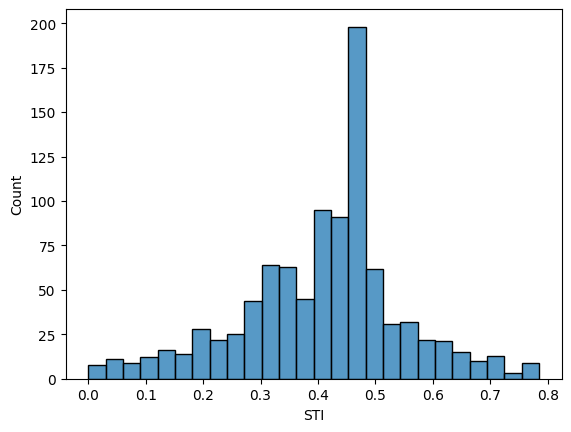

In [9]:
sns.histplot(evaluation_df,x='STI')
plt.show()

<i> Obs: 1. Most texts have STI of 0.48

1. High Style Transfer Examples

In [10]:
#Let us check some examples with high STI
max_sti_df = evaluation_df.sort_values(by='STI',ascending=False).head(n = 5) 

In [11]:
print("source text :" ,max_sti_df['Source Text'].iloc[0])
print("Target Text : ", max_sti_df['Target Text'].iloc[0])
print("Predicted Text : ", max_sti_df['Predicted Text'].iloc[0])


source text : some of funt's best pieces did not involve pranks but consisted simply of interviews with ordinary people.
Target Text :  some of funt's pieces did not involve pranks but consisted simply of interviews with ordinary people.
Predicted Text :  the the is the, the the the, the,,,,,,, the...


<i> Perfect Style Transfer

In [12]:
print("source text :" ,max_sti_df['Source Text'].iloc[1])
print("Target Text : ", max_sti_df['Target Text'].iloc[1])
print("Predicted Text : ", max_sti_df['Predicted Text'].iloc[1])


source text : in 1903 henri rochefort visited the auction of paintings that had been in zola's possession and published on 9 march 1903 in l'intransigeant a vicious article entitled love for the ugly.
Target Text :  in 1903 henri rochefort visited the auction of paintings that had been in zola's possession and published on 9 march 1903 in l'intransigeant a highly critical article entitled love for the ugly.
Predicted Text :  the the is the, the the the the the,,,,,,,,,,,,,,,,,,,,,,,,, the the...


In [13]:
print("source text :" ,max_sti_df['Source Text'].iloc[3])
print("Target Text : ", max_sti_df['Target Text'].iloc[3])
print("Predicted Text : ", max_sti_df['Predicted Text'].iloc[3])

source text : in vancouver, it was reported that most attendees at the event were hundreds of ogling men using camera phones to take pictures, especially of a small number of women who were topless.
Target Text :  in vancouver, it was reported that most attendees at the event were hundreds of men using camera phones to take pictures, especially of a small number of women who were topless.
Predicted Text :  the the is the, the the the the the,,,,,,,,,,,,,,,,,,,,,, the...


<b> High STI is when prediction text style matches perfecty with Target Text Style

2. Common Style Transfer examples. (STI = 0.32)

In [14]:
common_sti_df = evaluation_df[(evaluation_df['STI']>=0.3) & (evaluation_df['STI'] < 0.33)]

In [15]:
#Let us check some examples
common_sti_df = common_sti_df.sort_values(by='STI',ascending=False)

In [16]:
print("source text :" ,common_sti_df['Source Text'].iloc[3])
print("Target Text : ", common_sti_df['Target Text'].iloc[3])
print("Predicted Text : ", common_sti_df['Predicted Text'].iloc[3])

source text : as a u. s. congressman, thomas was a staunch right - wing opponent of president franklin delano roosevelt and his " new deal " claiming the president's legislative agenda had " sabotaged the capitalist system. "
Target Text :  as a u. s. congressman, thomas was a staunch conservative opponent of president franklin delano roosevelt and his " new deal " claiming the president's legislative agenda had " sabotaged the capitalist system. "
Predicted Text :  the the is the, the the the the the,,,,,,,,,,,,,,,,,,,,,,,,,,,, the the...


In [17]:
print("source text :" ,common_sti_df['Source Text'].iloc[10])
print("Target Text : ", common_sti_df['Target Text'].iloc[10])
print("Predicted Text : ", common_sti_df['Predicted Text'].iloc[10])

source text : despite clear evidence to the contrary, they claim that this layer of murky material was actually applied by michelangelo himself in order to " harmonise " what they called'ice - cream colours '.
Target Text :  despite evidence to the contrary, they claim that this layer of murky material was actually applied by michelangelo himself in order to " harmonise " what they called'ice - cream colours '.
Predicted Text :  the the is the, the the the the the,,,,,,,,,,,,,,,,,,,,,,, the the...


3. Low Style Transfer Examples

In [18]:
min_sti_df = evaluation_df[(evaluation_df['STI']>=0) & (evaluation_df['STI'] < 0.2)]

In [19]:
print("source text :" ,min_sti_df['Source Text'].iloc[15])
print("Target Text : ", min_sti_df['Target Text'].iloc[15])
print("Predicted Text : ", min_sti_df['Predicted Text'].iloc[15])

source text : the reason for this is that castilian nationalism was the first to have been destroyed by the spanish crown during the revolt and war of the castilian war of the communities against the spanish monarchy, between 1520 and 1521.
Target Text :  the reason for this is that castilian nationalism was the first to have been stopped by the spanish crown during the revolt and war of the castilian war of the communities against the spanish monarchy, between 1520 and 1521.
Predicted Text :  the the is the, the the the the the,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the the...


<i>No change in prediction 

## CPS

**1. Compute Word Attributions**
We get the word attributions in the subjective text. Word attributions give us the importance of each word in making in subjective in the context of the sentenence.

**2. Remove most biased words**
Remove the most biased word from the sentence.

**1. Compute Sentence Embeddings**

SentenceTransformer Model: The code uses a pre-trained model from the sentence-transformers library, specifically 'bert-base-nli-mean-tokens'. This model is designed to produce meaningful sentence embeddings for a wide range of texts.

Embeddings for Source and Predicted Texts: The model encodes both the source and predicted texts, converting them into high-dimensional vectors (embeddings) that represent their semantic content.

**2. Calculate Cosine Similarity for Content Preservation**

Cosine Similarity: This metric measures the cosine of the angle between two vectors. In the context of sentence embeddings, a higher cosine similarity indicates greater semantic similarity between texts.

Iterative Comparison: The code iterates over each pair of source and predicted embeddings, calculating the cosine similarity for each pair. This value ranges from -1 to 1, where 1 means identical directionality (high semantic similarity), 0 indicates orthogonality (no similarity), and -1 implies completely opposite directionality.

In [20]:
CLS_MODEL_PATH = "../../models/bert-finetuned"
model = AutoModelForSequenceClassification.from_pretrained(CLS_MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(CLS_MODEL_PATH)

In [21]:
def get_attributions(text):
	word_attributions = cls_explainer(text)
	# Create a DataFrame
	df_attrb = pd.DataFrame(word_attributions, columns=['token', 'score'])
	df_attrb["abs_norm"] = df_attrb['score'].abs()/df_attrb["score"].abs().sum()
	df_attrb = df_attrb.sort_values(by='abs_norm',ascending=False)
	df_attrb['abs_norm'] = df_attrb['abs_norm'].cumsum()
	df_attrb["cumulative"] = df_attrb["abs_norm"].cumsum()

	return df_attrb

In [22]:
def mask_style_words(text):
	atrrb_df = get_attributions(text)
	#remove the top scoring word
	#if length is less than 3, do not remove any word
	if len(atrrb_df['token']) <= 3:
		None
	else: 
		#if length more than 3 remove top score word
		
		#get the max score
		max_score = max(atrrb_df['score'])
        #list the words with subjectivity for future use
		subj_wrds = atrrb_df['token'][(atrrb_df['score']>=max_score)]
		non_subj_words = atrrb_df['token'][(atrrb_df['score']<max_score)]
		masked_text = non_subj_words.sort_index()[1:-1].str.cat(sep=' ')
		
	return masked_text

In [23]:
def get_cps_score(source_text, target_text):
	"""
	Calculates the content preservation score between the source text and the target text.

	Parameters:
	source_text (str): The original text.
	target_text (str): The modified text.

	Returns:
	float: The content preservation score between the source text and the target text.
	"""
	#generate embeddings (768 dimensional)
	source_embeddings = model_st.encode(source_text)
	predicted_embeddings = model_st.encode(target_text)
	content_scores = 1 - cosine(source_embeddings, predicted_embeddings)    
	
	return content_scores

In [25]:
test = 'Tajmahal is very beautiful'
word_attrn = cls_explainer(test)
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.96),LABEL_1,1.00,[CLS] ta ##jm ##aha ##l is very beautiful [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.96),LABEL_1,1.00,[CLS] ta ##jm ##aha ##l is very beautiful [SEP]


In [26]:
#calculte CPS
evaluation_df.head()

,Source Text,Target Text,Predicted Text,EMD Source-Predicted,EMD Target-Predicted,EMD Source-Target,STI
0,"in april 2009 a brazilian human rights group, ...","in april 2009 a brazilian human rights group, ...","the the is the, the the the the the,,,,,,,,,,,...",0.397700,0.300082,0.097618,0.468913
1,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,"the the is the, the the the the the,,,,,,,,,,,...",0.220731,0.369325,0.148595,0.253048
2,"mark oaten ( born 8 march 1964, watford ) is a...","mark oaten ( born 8 march 1964, watford ) is a...","the the is the, the the the the the,,,,,,,,,,,...",0.494251,0.456683,0.037568,0.482772
3,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,"the the is the, the the the the the the..",0.375979,0.350370,0.025609,0.418547
4,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,"the the is the, the the the the the the..",0.376436,0.375420,0.001016,0.405517


In [27]:
evaluation_df['CPS'] = evaluation_df.apply(lambda row: get_cps_score(row['Source Text'],row['Predicted Text']),axis=1)
evaluation_df

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,Source Text,Target Text,Predicted Text,EMD Source-Predicted,EMD Target-Predicted,EMD Source-Target,STI,CPS
0,"in april 2009 a brazilian human rights group, ...","in april 2009 a brazilian human rights group, ...","the the is the, the the the the the,,,,,,,,,,,...",0.397700,0.300082,0.097618,0.468913,0.051987
1,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,"the the is the, the the the the the,,,,,,,,,,,...",0.220731,0.369325,0.148595,0.253048,-0.065697
2,"mark oaten ( born 8 march 1964, watford ) is a...","mark oaten ( born 8 march 1964, watford ) is a...","the the is the, the the the the the,,,,,,,,,,,...",0.494251,0.456683,0.037568,0.482772,0.193853
3,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,"the the is the, the the the the the the..",0.375979,0.350370,0.025609,0.418547,0.339957
4,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,"the the is the, the the the the the the..",0.376436,0.375420,0.001016,0.405517,0.150046
...,...,...,...,...,...,...,...,...
958,especially as the cost to refurbish and modify...,especially as the cost to refurbish and modify...,"the the is the, the the the the the,,,,,,,,,,,...",0.109609,0.129399,0.019791,0.297065,0.167993
959,blood libels against jews are incorrect accusa...,blood libels against jews are accusations that...,"the the is the, the the the, the,,,,,,,, the...",0.485940,0.431483,0.054457,0.486547,0.023516
960,"jacob collier ( born august 2, 1994 ) is a sin...","jacob collier ( born august 2, 1994 ) is a sin...","the the is the, the the the the the,,,,,,,,,,,...",0.498571,0.481610,0.016962,0.475543,0.256812
961,they immediately decided to apply it to the an...,they immediately decided to apply it to the ne...,"the the is the, the the the the the the..",0.376617,0.097473,0.279144,0.589832,0.435434


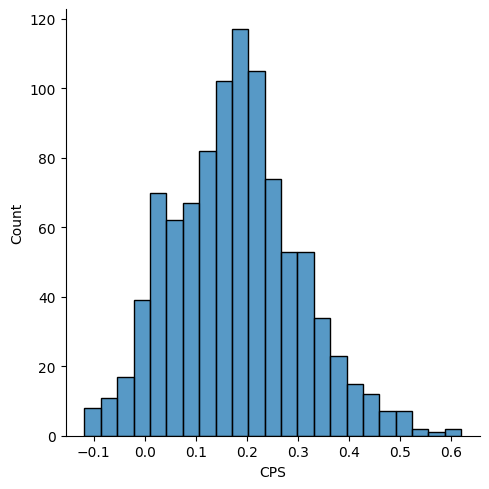

In [28]:
sns.displot(evaluation_df['CPS'])

Observtions:
1. Most texts have CPS of 0.1, meaning the content is not been preserved.
2. The predicted text are not retaining the semantic meaning of the source text. This is evident from the fact that the baseline model mostly predicts <"the", ".", ",">.

## Creating buckets for STI and CPS

1.  STI_buckets :
0.0 - 0.2 : bad
0.2 - 0.5 : good
greater than 0.5 : great

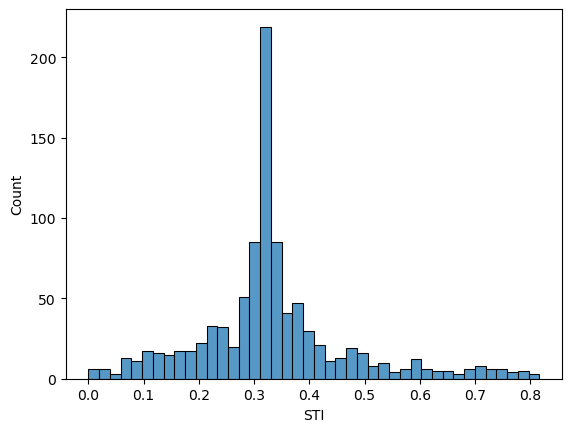

In [20]:
sns.histplot(evaluation_df,x='STI')
plt.show()

In [29]:
# Define the bins and labels for STI
bins = [0 ,0.15, 0.3, 0.5, 0.8]
labels = ['Bad', 'Decent','Good','Perfect']

# Create the new 'sti categories' column
evaluation_df['STI Categories'] = pd.cut(evaluation_df['STI'], bins=bins, labels=labels)

In [30]:
evaluation_df

,Source Text,Target Text,Predicted Text,EMD Source-Predicted,EMD Target-Predicted,EMD Source-Target,STI,CPS,STI Categories
0,"in april 2009 a brazilian human rights group, ...","in april 2009 a brazilian human rights group, ...","the the is the, the the the the the,,,,,,,,,,,...",0.397700,0.300082,0.097618,0.468913,0.051987,Good
1,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,"the the is the, the the the the the,,,,,,,,,,,...",0.220731,0.369325,0.148595,0.253048,-0.065697,Decent
2,"mark oaten ( born 8 march 1964, watford ) is a...","mark oaten ( born 8 march 1964, watford ) is a...","the the is the, the the the the the,,,,,,,,,,,...",0.494251,0.456683,0.037568,0.482772,0.193853,Good
3,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,"the the is the, the the the the the the..",0.375979,0.350370,0.025609,0.418547,0.339957,Good
4,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,"the the is the, the the the the the the..",0.376436,0.375420,0.001016,0.405517,0.150046,Good
...,...,...,...,...,...,...,...,...,...
958,especially as the cost to refurbish and modify...,especially as the cost to refurbish and modify...,"the the is the, the the the the the,,,,,,,,,,,...",0.109609,0.129399,0.019791,0.297065,0.167993,Decent
959,blood libels against jews are incorrect accusa...,blood libels against jews are accusations that...,"the the is the, the the the, the,,,,,,,, the...",0.485940,0.431483,0.054457,0.486547,0.023516,Good
960,"jacob collier ( born august 2, 1994 ) is a sin...","jacob collier ( born august 2, 1994 ) is a sin...","the the is the, the the the the the,,,,,,,,,,,...",0.498571,0.481610,0.016962,0.475543,0.256812,Good
961,they immediately decided to apply it to the an...,they immediately decided to apply it to the ne...,"the the is the, the the the the the the..",0.376617,0.097473,0.279144,0.589832,0.435434,Perfect


In [31]:
sti_category_proportions = evaluation_df['STI Categories'].value_counts(normalize=True)
sti_category_proportions.sort_values()

STI Categories
Bad        0.056133
Decent     0.136175
Perfect    0.181913
Good       0.625780
Name: proportion, dtype: float64

2. CPI Buckets : 

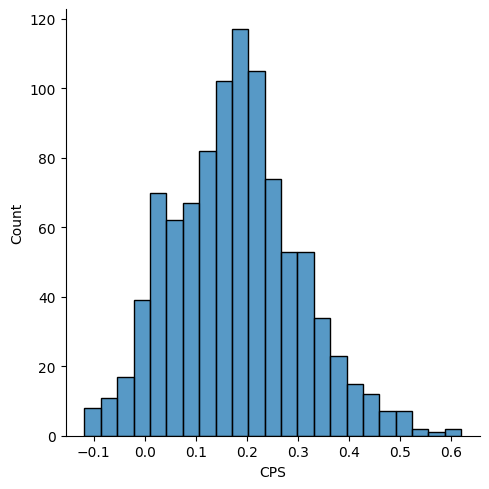

In [32]:
sns.displot(evaluation_df['CPS'])

In [33]:
# Define the bins and labels for STI
bins = [0 ,0.9, 0.95, 0.999, 1]
labels = ['Bad', 'Decent','Good','Perfect']
# Create the new 'sti categories' column
evaluation_df['CPS Categories'] = pd.cut(evaluation_df['CPS'], bins=bins, labels=labels)

cps_category_proportions = evaluation_df['CPS Categories'].value_counts(normalize=True)
cps_category_proportions.sort_values()

CPS Categories
Decent     0.0
Good       0.0
Perfect    0.0
Bad        1.0
Name: proportion, dtype: float64